In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# def hamiltonian_cycle(rows, cols, start=(0, 0)):
#     """
#     Generate a Hamiltonian cycle in a 2D grid starting from a given coordinate.
    
#     Args:
#         rows: Number of rows in the grid
#         cols: Number of columns in the grid
#         start: Starting coordinate as (row, col) tuple
        
#     Returns:
#         List of (row, col) coordinates representing the Hamiltonian cycle,
#         or None if no cycle exists
#     """
#     # Hamiltonian cycle only exists for grids where rows*cols is even
#     # or when both dimensions are odd and >= 3
#     if rows * cols % 2 == 1 and not (rows >= 3 and cols >= 3 and rows % 2 == 1 and cols % 2 == 1):
#         return None
    
#     visited = [[False] * cols for _ in range(rows)]
#     path = []
    
#     def is_valid(r, c):
#         return 0 <= r < rows and 0 <= c < cols and not visited[r][c]
    
#     def count_unvisited_neighbors(r, c):
#         count = 0
#         for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
#             nr, nc = r + dr, c + dc
#             if is_valid(nr, nc):
#                 count += 1
#         return count
    
#     def backtrack(r, c):
#         visited[r][c] = True
#         path.append((r, c))
        
#         # If we've visited all cells
#         if len(path) == rows * cols:
#             # Check if we can return to start
#             sr, sc = start
#             if abs(r - sr) + abs(c - sc) == 1:
#                 return True
#             else:
#                 # Try to find a path back
#                 path.pop()
#                 visited[r][c] = False
#                 return False
        
#         # Try neighbors using Warnsdorff's heuristic (visit least-connected first)
#         neighbors = []
#         for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
#             nr, nc = r + dr, c + dc
#             if is_valid(nr, nc):
#                 priority = count_unvisited_neighbors(nr, nc)
#                 neighbors.append((priority, nr, nc))
        
#         neighbors.sort()
        
#         for _, nr, nc in neighbors:
#             if backtrack(nr, nc):
#                 return True
        
#         # Backtrack
#         path.pop()
#         visited[r][c] = False
#         return False
    
#     if backtrack(start[0], start[1]):
#         return path
#     else:
#         return None


# # Example usage
# if __name__ == "__main__":
#     # Generate a cycle for a 4x4 grid starting at (0, 0)
#     cycle = hamiltonian_cycle(5, 5, start=(0, 0))
    
#     if cycle:
#         print(f"Found Hamiltonian cycle with {len(cycle)} vertices:")
#         print("Path:", cycle)
        
#         # Visualize the cycle
#         grid = [[-1] * 6 for _ in range(6)]
#         for i, (r, c) in enumerate(cycle):
#             grid[r][c] = i
        
#         print("\nVisualization (order of visit):")
#         for row in grid:
#             print(" ".join(f"{x:3d}" for x in row))
#     else:
#         print("No Hamiltonian cycle found")

In [3]:
import sys

# sys.path.append('../')
import GTPyhop.gtpyhop as gtpyhop
import pddlgym
import matplotlib.pyplot as plt
from path_finding import Coord, PathSolver, Coord


Imported GTPyhop version 1.0.
Messages from find_plan will be prefaced with 'FP>'.
Messages from run_lazy_lookahead will be prefaced with 'RLL>'.


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [4]:
PATH_TO_GYM = "pddlgym/"
domain_name = "snake"
problem_name = "PDDLEnvSnake-v0"
domain = gtpyhop.Domain(domain_name)
domain

Domain('snake', _action_dict={}, _command_dict={}, _task_method_dict={'_verify_g': [<function _m_verify_g at 0x10603a440>], '_verify_mg': [<function _m_verify_mg at 0x10603a4d0>]}, _unigoal_method_dict={}, _multigoal_method_list=[])

In [5]:
'''
Define rigid relations for the domain
'''

rigid = gtpyhop.State('rigid relations')

# snake domain is only coordinates/fields according to problem size
# p01/pddl is a 5x5 grid, so coords are (0,0) to (4,4)

size = 5
coords = []
for i in range(size):
    for j in range(size):
        coord = f'pos{i}-{j}'
        coords.append(coord)

coords.append('dummypoint')

rigid.types = {
    'coord': coords,
}

# Helper
def is_a(variable,type):
    """
    In most classical planners, one would declare data-types for the parameters
    of each action, and the data-type checks would be done by the planner.
    GTPyhop doesn't have a way to do that, so the 'is_a' function gives us a
    way to do it in the preconditions of each action, command, and method.
    
    'is_a' doesn't implement subtypes (e.g., if rigid.type[x] = y and
    rigid.type[x] = z, it doesn't infer that rigid.type[x] = z. It wouldn't be
    hard to implement this, but it isn't needed in the simple-travel domain.
    """
    return variable in rigid.types[type]

rigid

State('rigid relations', types={'coord': ['pos0-0', 'pos0-1', 'pos0-2', 'pos0-3', 'pos0-4', 'pos1-0', 'pos1-1', 'pos1-2', 'pos1-3', 'pos1-4', 'pos2-0', 'pos2-1', 'pos2-2', 'pos2-3', 'pos2-4', 'pos3-0', 'pos3-1', 'pos3-2', 'pos3-3', 'pos3-4', 'pos4-0', 'pos4-1', 'pos4-2', 'pos4-3', 'pos4-4', 'dummypoint']})

In [6]:
# define initial state for p01
if problem_name == "PDDLEnvSnake-v0":
    initial = gtpyhop.State('state0')
    initial.grid_size = size

    # point adjacency relations
    isadjacent = {'dummypoint': []}

    for i in range(size):
        for j in range(size):
            coord = f'pos{i}-{j}'
            adjacent_coords = []
            # up
            if i > 0:
                adjacent_coords.append(f'pos{i-1}-{j}')
            # down
            if i < size - 1:
                adjacent_coords.append(f'pos{i+1}-{j}')
            # left
            if j > 0:
                adjacent_coords.append(f'pos{i}-{j-1}')
            # right
            if j < size - 1:
                adjacent_coords.append(f'pos{i}-{j+1}')
            isadjacent[coord] = adjacent_coords

    initial.isadjacent = isadjacent

    # snake spawn + point spawns
    # set initial tail position
    tailsnake  = 'pos3-0'
    initial.tailsnake = {tailsnake: True} | {coord: False for coord in rigid.types['coord'] if coord != tailsnake}

    # set initial head position
    headsnake = 'pos4-0'
    initial.headsnake = {headsnake: True} | {coord: False for coord in rigid.types['coord'] if coord != headsnake}

    # initial nextsnake position
    nextsnake = {headsnake: tailsnake}
    initial.nextsnake = nextsnake | {coord: None for coord in rigid.types['coord'] if coord not in nextsnake.keys()}

    # set blocked positions (obstacles + snake spawnpoints)
    # NOTE: no obstacles in p01
    blocked_pos = []
    blocked_pos.extend([tailsnake, headsnake])
    initial.blocked = {coord: True for coord in blocked_pos} | {coord: False for coord in rigid.types['coord'] if coord not in blocked_pos}
    
    # set initial food spawn
    spawn = 'pos2-0'
    initial.spawn = {spawn: True} | {coord: False for coord in rigid.types['coord'] if coord != spawn}

    # nextspawn relations
    nextspawn = {
        'pos1-0' :'dummypoint',
        'pos2-0' :'pos1-4',
        'pos1-4' :'pos1-1',
        'pos1-1' :'pos0-1',
        'pos0-1' :'pos3-3',
        'pos3-3' :'pos4-2',
        'pos4-2' :'pos3-4',
        'pos3-4' :'pos0-0',
        'pos0-0' :'pos1-2',
        'pos1-2' :'pos1-0'
    }

    initial.nextspawn = nextspawn | {coord: None for coord in rigid.types['coord'] if coord not in nextspawn.keys()}

    # ispoint
    ispoint = ['pos0-4', 'pos3-1', 'pos1-3', 'pos2-4', 'pos4-1']
    initial.ispoint = {coord: True for coord in ispoint} | {coord: False for coord in rigid.types['coord'] if coord not in ispoint}

else:
    raise NotImplementedError("Only PDDLEnvSnake-v0 is implemented")

In [7]:
# Actions

# NOTE: not bothering to check types since everything is_a coord

def move(state, head, newhead, tail, newtail):
    
    if state.headsnake[head] and \
       newhead in state.isadjacent[head] and \
       state.tailsnake[tail] and \
       state.nextsnake[newtail] == tail and \
       not state.blocked[newhead] and \
       not state.ispoint[newhead]:

        state.blocked[newhead] = True
        state.headsnake[newhead] = True
        state.nextsnake[newhead] = head
        state.headsnake[head] = False
        state.blocked[tail] = False
        state.tailsnake[tail] = False
        state.nextsnake[newtail] = None
        state.tailsnake[newtail] = True

        return state


# eat food and spawn new food
def move_and_eat_spawn(state, head, newhead, spawnpoint, nextspawnpoint):
    

    print("\nmove_and_eat_spawn called")

    if state.headsnake[head] and \
       newhead in state.isadjacent[head] and \
       not state.blocked[newhead] and \
       state.ispoint[newhead] and \
       state.spawn[spawnpoint] and \
       state.nextspawn[spawnpoint] == nextspawnpoint and \
       spawnpoint != 'dummypoint':
        
        state.blocked[newhead] = True
        state.headsnake[newhead] = True
        state.nextsnake[newhead] = head
        state.headsnake[head] = False
        state.ispoint[newhead] = False
        state.ispoint[spawnpoint] = True
        state.spawn[spawnpoint] = False
        state.spawn[nextspawnpoint] = True

        return state

# eat food but no new spawn
def move_and_eat_no_spawn(state, head, newhead):

    # print("\nmove_and_eat_no_spawn called")
    # print(f'{state.headsnake[head]}')
    
    if state.headsnake[head] and \
       newhead in state.isadjacent[head] and \
       not state.blocked[newhead] and \
       state.ispoint[newhead] and \
       state.spawn['dummypoint']:
        
        state.blocked[newhead] = True
        state.headsnake[newhead] = True
        state.nextsnake[newhead] = head
        state.headsnake[head] = False
        state.ispoint[newhead] = False

        return state
    

gtpyhop.declare_actions(move, move_and_eat_spawn, move_and_eat_no_spawn)



{'move': <function __main__.move(state, head, newhead, tail, newtail)>,
 'move_and_eat_spawn': <function __main__.move_and_eat_spawn(state, head, newhead, spawnpoint, nextspawnpoint)>,
 'move_and_eat_no_spawn': <function __main__.move_and_eat_no_spawn(state, head, newhead)>}

In [8]:

# commands (equivalent to actions here)

# def c_move(state, head, newhead, tail, newtail):
    
#     if state.headsnake[head] and \
#        newhead in state.isadjacent[head] and \
#        state.tailsnake[tail] and \
#        state.nextsnake[newtail] == tail and \
#        not state.blocked[newhead] and \
#        not state.ispoint[newhead]:

#         state.blocked[newhead] = True
#         state.headsnake[newhead] = True
#         state.nextsnake[newhead] = head
#         state.headsnake[head] = False
#         state.blocked[tail] = False
#         state.tailsnake[tail] = False
#         state.nextsnake[newtail] = None
#         state.tailsnake[newtail] = True

#         return state


# # eat food and spawn new food
# def c_move_and_eat_spawn(state, head, newhead, spawnpoint, nextspawnpoint):
    
#     if state.headsnake[head] and \
#        newhead in state.isadjacent[head] and \
#        not state.blocked[newhead] and \
#        state.ispoint[newhead] and \
#        state.spawn[spawnpoint] and \
#        state.nextspawn[spawnpoint] == nextspawnpoint and \
#        spawnpoint != 'dummypoint':
        
#         state.blocked[newhead] = True
#         state.headsnake[newhead] = True
#         state.nextsnake[newhead] = head
#         state.headsnake[head] = False
#         state.ispoint[newhead] = False
#         state.ispoint[spawnpoint] = True
#         state.spawn[spawnpoint] = False
#         state.spawn[nextspawnpoint] = True

#         return state

# # eat food but no new spawn
# def c_move_and_eat_no_spawn(state, head, newhead):
    
#     if state.headsnake[head] and \
#        newhead in state.isadjacent[head] and \
#        not state.blocked[newhead] and \
#        state.ispoint[newhead] and \
#        state.spawn['dummypoint']:
        
#         state.blocked[newhead] = True
#         state.headsnake[newhead] = True
#         state.nextsnake[newhead] = head
#         state.headsnake[head] = False
#         state.ispoint[newhead] = False

#         return state
    
# gtpyhop.declare_commands(c_move, c_move_and_eat_spawn, c_move_and_eat_no_spawn)

# # Methods
# def move_to_food(state, food_coord, food_status):

#     # print(f'arg0: {arg0}')
#     # print(f'arg1: {arg1}')
#     # print(f'arg2: {arg2}')

#     print("move_to_food method called")

#     # food has been collected or not spawned yet
#     if state.ispoint[food_coord] == food_status:
#         return []
    
#     # snake can collect food at food_coord + spawn

#     # snake can collect food at food_coord + no spawn

#     # move snake closer to food_coord
#     else:
#         pass

# gtpyhop.declare_unigoal_methods('ispoint', move_to_food)



In [9]:
def pyhop_to_coord(pyhop_pos:str):
    split = pyhop_pos.split('-')
    return Coord(int(split[0][-1]), int(split[1][-1]))

def coord_to_pyhop(coord:Coord):
    return f'pos{coord.x}-{coord.y}'

def get_all_active_food(state):
    return [key for key,val in state.ispoint.items() if val]

def get_snake_head(state):
    snake_head = [key for key,val in state.headsnake.items() if val]
    assert len(snake_head) == 1, "Error: Multiple snake heads found"
    return snake_head[0]

def get_snake_coords(state):
    coords = []
    cur = get_snake_head(state)
    while cur is not None:
        coords.append(pyhop_to_coord(cur))
        cur = state.nextsnake[cur]
    return coords

def get_next_spawnpoints(state):
    # only one spawnpoint/nextspawnpoint active at a time
    spawnpoint = [s for s,v in state.spawn.items() if v][0]
    nextspawnpoint = state.nextspawn[spawnpoint]
    return spawnpoint, nextspawnpoint

# create gtpyhop action to move snake to given coord
def make_move_action_to_coord(state, snake_coords, coord:Coord):

    newhead = coord_to_pyhop(coord)
    head = coord_to_pyhop(snake_coords[0])

    # check if coord is occupied by food
    if not state.ispoint[newhead]:

        head = coord_to_pyhop(snake_coords[0])
        newtail = coord_to_pyhop(snake_coords[-2])
        tail = coord_to_pyhop(snake_coords[-1])

        return ('move', head, newhead, tail, newtail)
    
    # no more food spawns
    elif state.spawn['dummypoint']:
        return ('move_and_eat_no_spawn', head, newhead)

    # food spawns available 
    else:
        spawnpoint, nextspawnpoint = get_next_spawnpoints(state)
        return ('move_and_eat_spawn', head, newhead, spawnpoint, nextspawnpoint)



# get_next_spawnpoints(initial)

In [10]:
def check_multigoal_achieved(state, multigoal):
    for goal_k, goal_v in multigoal.ispoint.items():
        state_v = state.ispoint[goal_k]
        if state_v != goal_v:
            return False
    return True

In [11]:

def m_get_all_food_multigoal(state, multigoal):
    print(f'multigoal: {multigoal.ispoint}')
    print("m_get_all_food_multigoal method called")
    print('all active food:', get_all_active_food(state))
    print('snake head:', get_snake_head(state))
    # print(f'snake coords:', get_snake_coords(state))

    # check if multigoal achieved!
    if check_multigoal_achieved(state, multigoal):
        return []

    # TODO: determine optimal food ordering sequence to minimize moves

    # return []
    print(f'headsnake: {state.headsnake}')
    # print(state.isadjacent[state.headsnake])

    # determine manhattan distances to all food points
    snake_coords = get_snake_coords(state)
    head_coord = snake_coords[0]
    food_coords = [pyhop_to_coord(food) for food in get_all_active_food(state)]

    min_dist = float('inf')
    closest_food = None

    for food_coord in food_coords:

        # avoid pursuing a food that is currently occupied by the snake body
        if food_coord not in snake_coords:
            dist = Coord.manhattan_dist(head_coord, food_coord)

            if dist < min_dist:
                min_dist = dist
                closest_food = food_coord
    
    
    # greedily pursue unigoal towards closest food
    closest_food = coord_to_pyhop(closest_food)
    return [('ispoint', closest_food, False), multigoal]
    

# gtpyhop.declare_multigoal_methods(gtpyhop.m_split_multigoal)

gtpyhop.declare_multigoal_methods(m_get_all_food_multigoal)

[<function __main__.m_get_all_food_multigoal(state, multigoal)>]

In [12]:

# unigoal to collect food at food_coord
# pyhop check is setting ispoint[food_coord] to False == val
def m_get_food_unigoal(state, food_point, val):
    print(f'\nm_get_food_unigoal called for food at {food_point}')

    # unigoal acheived
    if state.ispoint[food_point] == val:
        return []

    # determine snake coords
    snake_coords = get_snake_coords(state)
    print(f'snake coords: {snake_coords}')
    
    # check if this is the final food piece
    final_food = (len(get_all_active_food(state)) == 1) and state.spawn['dummypoint']

    # create path solver
    ps = PathSolver(snake_coords, grid_size=(state.grid_size, state.grid_size))
    food_coord = pyhop_to_coord(food_point)
    tail_coord:Coord = snake_coords[-1]
    head_coord:Coord = snake_coords[0]

    # take step towards food if path exists
    path_to_food = ps.shortest_path_to_coord(food_coord)

    # print(f'make_move_action_to_coord: {make_move_action_to_coord(state, snake_coords, next_coord)}')

    # no need to worry about deadlock if this is the final food piece
    if path_to_food and final_food:
        # step towards food
        next_coord = head_coord.adj(path_to_food[0])
        return [make_move_action_to_coord(state, snake_coords, next_coord), ('ispoint', food_point, val)]

    else:
        # check if path to tail exists (to avoid deadlock)
        path_to_tail = ps.longest_path_to_coord(tail_coord)
        if len(path_to_tail) > 1:
            # step towards food
            if path_to_food:
                next_coord = head_coord.adj(path_to_food[0])
            # step towards tail
            else:
                next_coord = head_coord.adj(path_to_tail[0])
        
        # TODO:
        else:
            print('TODO: no path to tail, have to make risky move')
            
            # direc = snake_coords[1].direc_to(head_coord)
            max_dist = -1

            for adj in head_coord.all_adj():
                if ps.is_safe(adj):
                    dist = Coord.manhattan_dist(adj, food_coord)
                    if dist > max_dist:
                        max_dist = dist
                        next_coord = adj
    
    return [make_move_action_to_coord(state, snake_coords, next_coord), ('ispoint', food_point, val)]

    # return []

  

    
gtpyhop.declare_unigoal_methods('ispoint', m_get_food_unigoal)


{'ispoint': [<function __main__.m_get_food_unigoal(state, food_point, val)>]}

In [13]:
gtpyhop.current_domain.display()


Domain name: snake
-- Actions: move, move_and_eat_spawn, move_and_eat_no_spawn
-- There are no commands --

Task name:         Relevant task methods:
---------------    ----------------------
_verify_g          _m_verify_g
_verify_mg         _m_verify_mg

State var name:    Relevant unigoal methods:
---------------    -------------------------
ispoint            m_get_food_unigoal

-- Multigoal methods: m_get_all_food_multigoal


In [14]:
# TODO: modify for different problems
if problem_name == "PDDLEnvSnake-v0":

    multigoal = gtpyhop.Multigoal('multigoal')
    multigoal.ispoint = {
        'pos0-4': False,
        'pos3-1': False,
        'pos1-3': False,
        'pos2-4': False,
        'pos4-1': False,
        'pos2-0': False,
        'pos1-4': False,
        'pos1-1': False,
        'pos0-1': False,
        'pos3-3': False,
        'pos4-2': False,
        'pos3-4': False,
        'pos0-0': False,
        'pos1-2': False,
        'pos1-0': False,
    }

gtpyhop.verbose = 3
result = gtpyhop.find_plan(initial, [multigoal])

FP> find_plan, verbose=3:
    state = state0
    todo_list = [<Multigoal multigoal>]
depth 0 todo_list [<Multigoal multigoal>]
depth 0 multigoal <Multigoal multigoal>: methods ['m_get_all_food_multigoal']
depth 0 trying method m_get_all_food_multigoal: multigoal: {'pos0-4': False, 'pos3-1': False, 'pos1-3': False, 'pos2-4': False, 'pos4-1': False, 'pos2-0': False, 'pos1-4': False, 'pos1-1': False, 'pos0-1': False, 'pos3-3': False, 'pos4-2': False, 'pos3-4': False, 'pos0-0': False, 'pos1-2': False, 'pos1-0': False}
m_get_all_food_multigoal method called
all active food: ['pos0-4', 'pos3-1', 'pos1-3', 'pos2-4', 'pos4-1']
snake head: pos4-0
headsnake: {'pos4-0': True, 'pos0-0': False, 'pos0-1': False, 'pos0-2': False, 'pos0-3': False, 'pos0-4': False, 'pos1-0': False, 'pos1-1': False, 'pos1-2': False, 'pos1-3': False, 'pos1-4': False, 'pos2-0': False, 'pos2-1': False, 'pos2-2': False, 'pos2-3': False, 'pos2-4': False, 'pos3-0': False, 'pos3-1': False, 'pos3-2': False, 'pos3-3': False, 'po

In [15]:
result

[('move_and_eat_spawn', 'pos4-0', 'pos4-1', 'pos2-0', 'pos1-4'),
 ('move_and_eat_spawn', 'pos4-1', 'pos3-1', 'pos1-4', 'pos1-1'),
 ('move', 'pos3-1', 'pos2-1', 'pos3-0', 'pos4-0'),
 ('move_and_eat_spawn', 'pos2-1', 'pos2-0', 'pos1-1', 'pos0-1'),
 ('move', 'pos2-0', 'pos1-0', 'pos4-0', 'pos4-1'),
 ('move_and_eat_spawn', 'pos1-0', 'pos1-1', 'pos0-1', 'pos3-3'),
 ('move_and_eat_spawn', 'pos1-1', 'pos0-1', 'pos3-3', 'pos4-2'),
 ('move', 'pos0-1', 'pos0-2', 'pos4-1', 'pos3-1'),
 ('move', 'pos0-2', 'pos0-3', 'pos3-1', 'pos2-1'),
 ('move_and_eat_spawn', 'pos0-3', 'pos0-4', 'pos4-2', 'pos3-4'),
 ('move_and_eat_spawn', 'pos0-4', 'pos1-4', 'pos3-4', 'pos0-0'),
 ('move_and_eat_spawn', 'pos1-4', 'pos1-3', 'pos0-0', 'pos1-2'),
 ('move', 'pos1-3', 'pos2-3', 'pos2-1', 'pos2-0'),
 ('move_and_eat_spawn', 'pos2-3', 'pos2-4', 'pos1-2', 'pos1-0'),
 ('move_and_eat_spawn', 'pos2-4', 'pos3-4', 'pos1-0', 'dummypoint'),
 ('move_and_eat_no_spawn', 'pos3-4', 'pos3-3'),
 ('move', 'pos3-3', 'pos3-2', 'pos2-0', 'po

In [16]:
env = pddlgym.make('PDDLEnvSnake-v0')

obs, debuginfo = env.reset()
env.action_predicates[0]


move-and-eat-spawn

In [17]:
def convert_htn_plan_to_pddlgym(result):

    name_to_predicate = {pred.name: pred for pred in env.action_predicates}

    print(name_to_predicate)

    return [pddlgym.structs.Literal(name_to_predicate[act[0].replace('_', '-')], list(act[1:])) for act in result]

plan = convert_htn_plan_to_pddlgym(result)
plan

{'move-and-eat-spawn': move-and-eat-spawn, 'move': move, 'move-and-eat-no-spawn': move-and-eat-no-spawn}


[move-and-eat-spawn(pos4-0:default,pos4-1:default,pos2-0:default,pos1-4:default),
 move-and-eat-spawn(pos4-1:default,pos3-1:default,pos1-4:default,pos1-1:default),
 move(pos3-1:default,pos2-1:default,pos3-0:default,pos4-0:default),
 move-and-eat-spawn(pos2-1:default,pos2-0:default,pos1-1:default,pos0-1:default),
 move(pos2-0:default,pos1-0:default,pos4-0:default,pos4-1:default),
 move-and-eat-spawn(pos1-0:default,pos1-1:default,pos0-1:default,pos3-3:default),
 move-and-eat-spawn(pos1-1:default,pos0-1:default,pos3-3:default,pos4-2:default),
 move(pos0-1:default,pos0-2:default,pos4-1:default,pos3-1:default),
 move(pos0-2:default,pos0-3:default,pos3-1:default,pos2-1:default),
 move-and-eat-spawn(pos0-3:default,pos0-4:default,pos4-2:default,pos3-4:default),
 move-and-eat-spawn(pos0-4:default,pos1-4:default,pos3-4:default,pos0-0:default),
 move-and-eat-spawn(pos1-4:default,pos1-3:default,pos0-0:default,pos1-2:default),
 move(pos1-3:default,pos2-3:default,pos2-1:default,pos2-0:default),
 mov

In [20]:
print(len(plan))

27


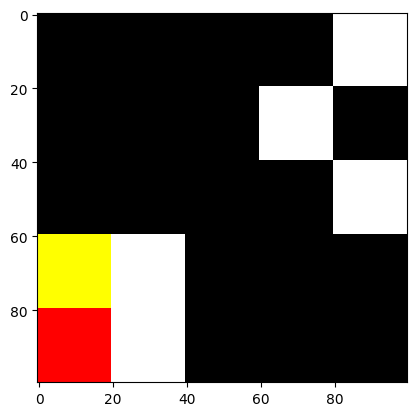

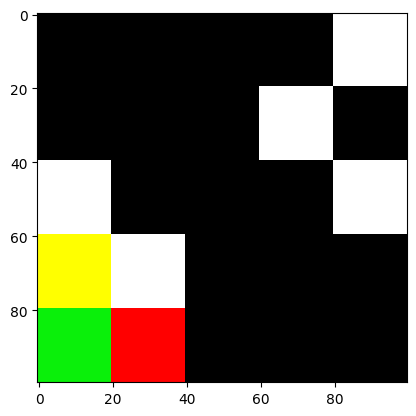

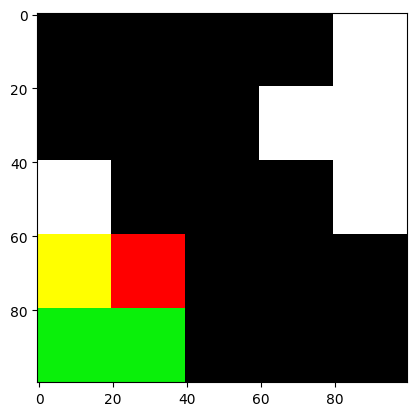

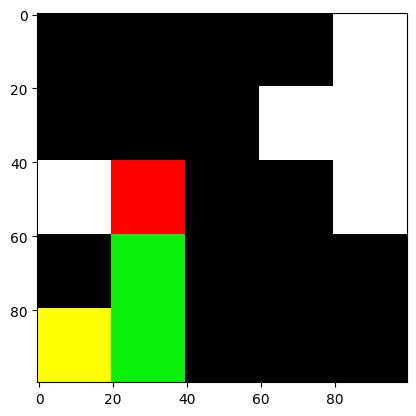

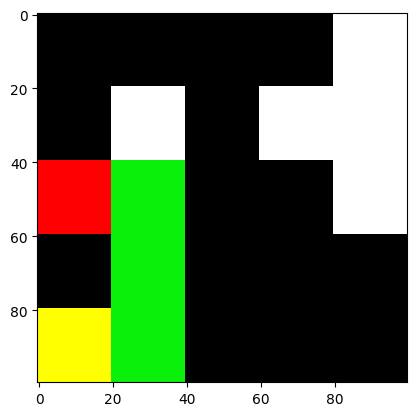

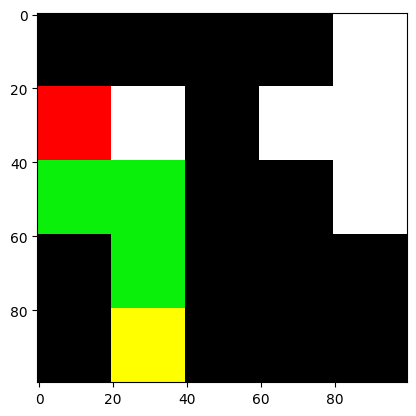

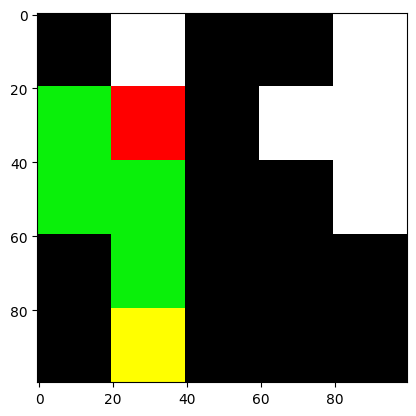

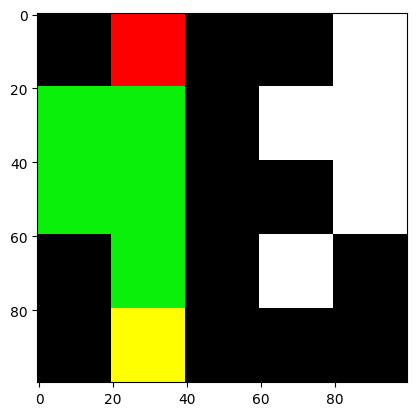

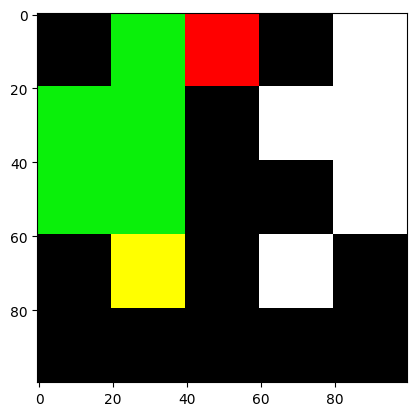

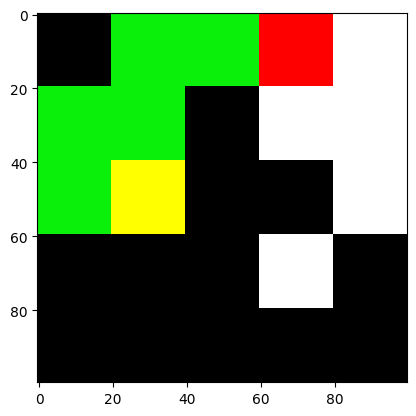

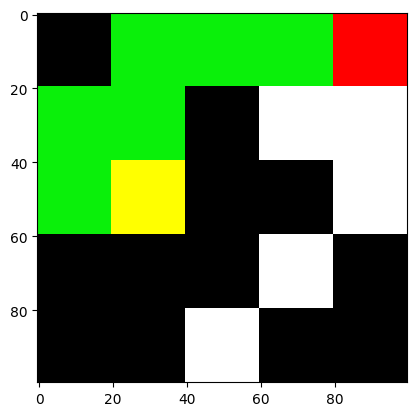

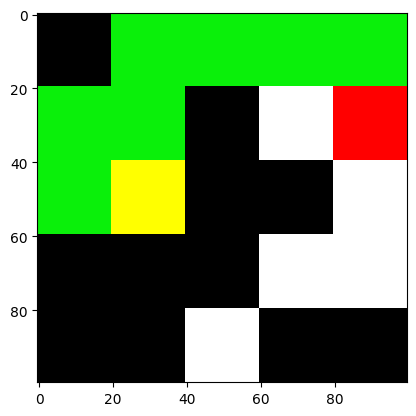

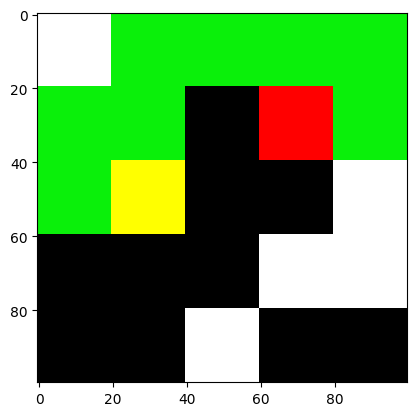

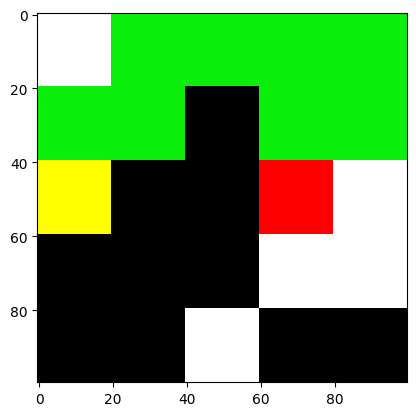

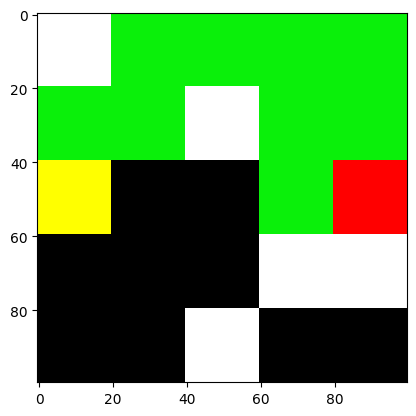

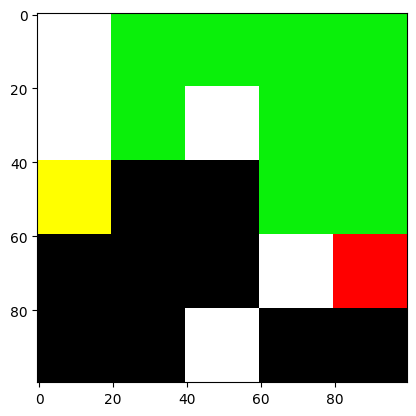

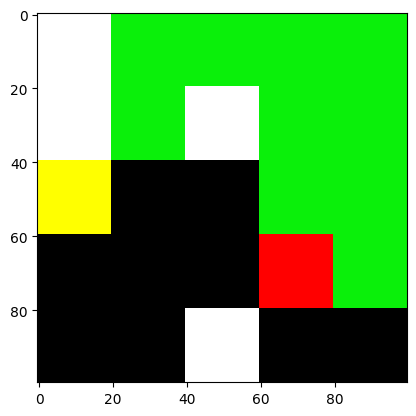

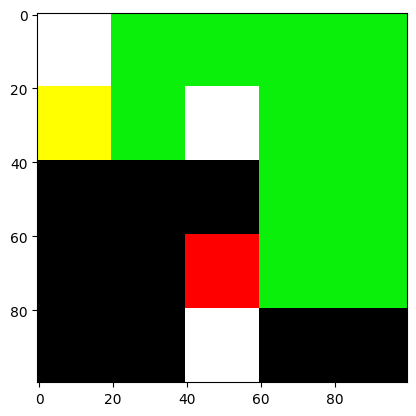

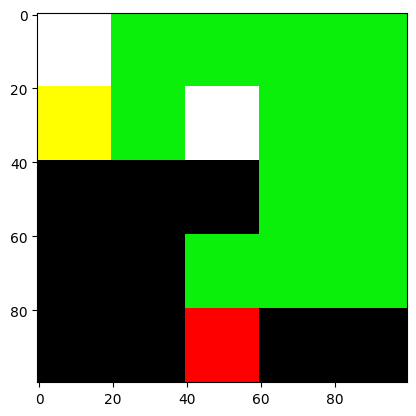

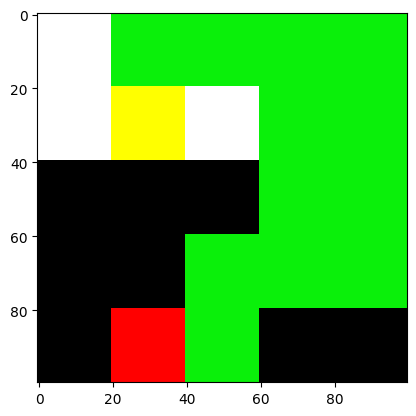

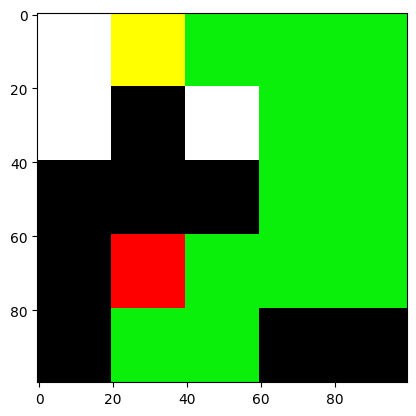

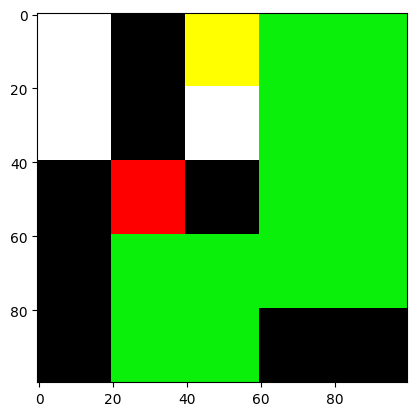

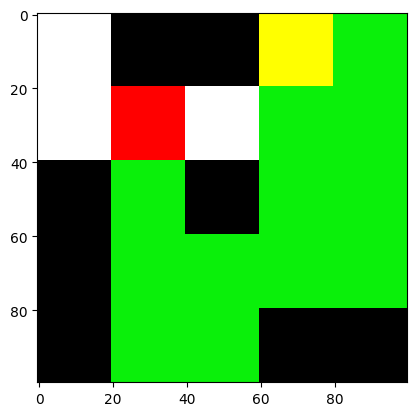

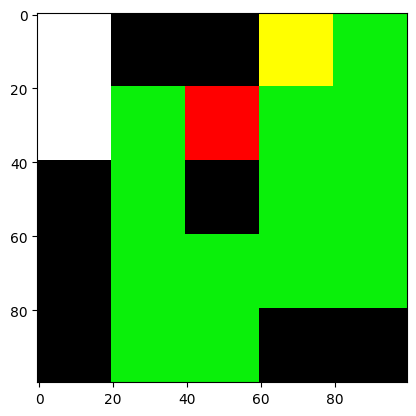

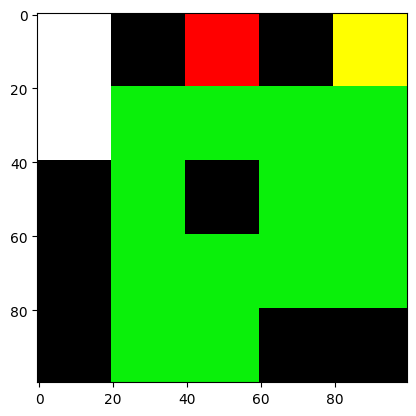

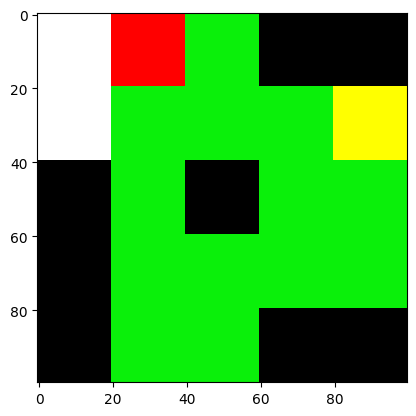

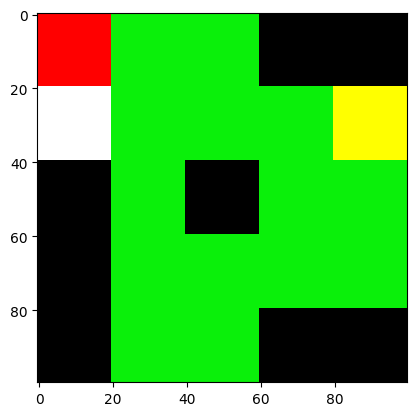

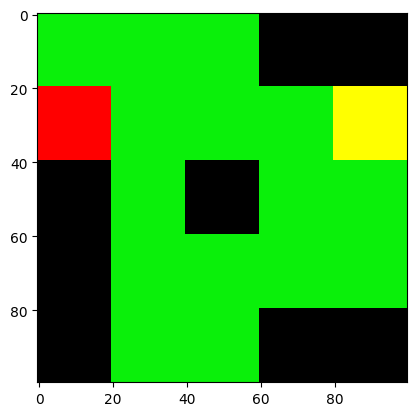

In [18]:
plt.imshow(env.render())
plt.show()

for act in plan:
    obs, reward, done, truncated, debug_info = env.step(act)
    plt.imshow(env.render())
    plt.show()

In [19]:
# literal = initial.ispoint
# print(len(literal))
# literal